In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import torch
import torch.nn as nn

In [3]:
device = 'cpu'

In [4]:
from copy import deepcopy

def prepare_shifted_df(df, n_steps, input_name):
    df = deepcopy(df)
    
    # df.set_index('Month', inplace=True)
    
    for i in reversed(range(1, n_steps + 1)):
        new_name = input_name + f"(t-{i})"
        df[new_name] = df.iloc[:,0].shift(i)
        
    df.dropna(inplace=True)
    
    return df.iloc[:,1:]

lookback = 36

In [5]:
df = pd.read_csv('../Data/Employment_pch_1960.csv')
df = df.iloc[:-1,1:]
df.set_index('Month', inplace=True)
# print(df)
shifted_df0 = prepare_shifted_df(df[['Total_private_pch']], lookback, 'Total_private_pch')

df = pd.read_csv('../Data/Input_features_1960.csv')
df = df.iloc[:,1:]
df.set_index('Month', inplace=True)
# print(df)
shifted_df1 = prepare_shifted_df(df[['Fedfund_rate']], lookback, 'Fedfund_rate')
shifted_df2 = prepare_shifted_df(df[['GDP_pch']], lookback, 'GDP_pch')
shifted_df3 = prepare_shifted_df(df[['CPI_pc1']], lookback, 'CPI_pc1')
shifted_df4 = prepare_shifted_df(df[['Loan_pch']], lookback, 'Loan_pch')
shifted_df5 = prepare_shifted_df(df[['House_ch']], lookback, 'House_ch')

In [6]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))

def scale_df(df, scaler):
    df_np = df.to_numpy()
    return scaler.fit_transform(df_np)

X shape is (729, 36, 6)


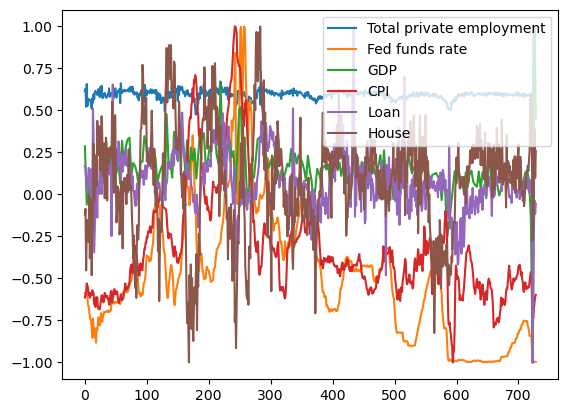

array([False, False, False, False, False, False])

In [7]:
X0 = scale_df(shifted_df0, scaler)
X1 = scale_df(shifted_df1, scaler)
X2= scale_df(shifted_df2, scaler)
X3 = scale_df(shifted_df3, scaler)
X4 = scale_df(shifted_df4, scaler)
X5 = scale_df(shifted_df5, scaler)

temp_list = [X0, X1, X2, X3, X4, X5]
# print(X0)
# print(type(X0.shape[0]))
X = np.zeros([X0.shape[0], X0.shape[1], 6])
# X.shape
for i in range(6):
    X[:,:,i] = temp_list[i]
    
print(f"X shape is {X.shape}")
# plt.plot(X[:,:,0])
plt.plot(X0[:,0], label = 'Total private employment')
plt.plot(X1[:,0], label = 'Fed funds rate')
plt.plot(X2[:,0], label = 'GDP')
plt.plot(X3[:,0], label = 'CPI')
plt.plot(X4[:,0], label = 'Loan')
plt.plot(X5[:,0], label = 'House')

plt.legend()
plt.show()

np.isnan(X).any(0).any(0)

In [8]:
y_df = pd.read_csv('../Data/Employment_pch_1960.csv')

y_df = y_df[['Month', 'Total_private_pch']]
y_df = y_df.iloc[lookback:-1,:]
y_df.set_index('Month', inplace = True)
print(y_df)
# assert(y_df.shape[0] == X.shape[0])
                                 
# shifted_df1
y = y_df.to_numpy()
# y = shifted_df_as_np[:, 0]
y_dir = np.sign(y)
y_dir[y_dir == -1] = 0
y_dir = y_dir[:,0]
# y_dir
# X = dc(np.flip(X, axis=1)) # because we want to start from the earliest time)
# # X

X.shape, y_dir.shape

            Total_private_pch
Month                        
1963-01-01            0.01919
1963-02-01            0.18759
1963-03-01            0.16171
1963-04-01            0.51195
1963-05-01            0.02536
...                       ...
2023-05-01            0.19161
2023-06-01            0.06450
2023-07-01            0.10867
2023-08-01            0.08535
2023-09-01            0.18401

[729 rows x 1 columns]


((729, 36, 6), (729,))

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_dir, test_size=0.2, shuffle = True, random_state=8)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((583, 36, 6), (146, 36, 6), (583,), (146,))

In [10]:
#add another dimension in the end for Pytorch LSTM
# num_classes = 2
# X_train = X_train.reshape((-1, lookback, 1))
# X_test = X_test.reshape((-1, lookback, 1))

# y_train = y_train.reshape((-1, 1))
# y_test = y_test.reshape((-1, 1))



# X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [11]:
X_train = torch.tensor(X_train, dtype = torch.float32)
X_test = torch.tensor(X_test, dtype = torch.float32)
y_train = torch.tensor(y_train, dtype = torch.long)
y_test = torch.tensor(y_test, dtype = torch.long)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([583, 36, 6]),
 torch.Size([146, 36, 6]),
 torch.Size([583]),
 torch.Size([146]))

In [14]:
temp = np.nonzero(y_test < 0)
len(temp)

0

In [11]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)
train_dataset

In [12]:
#wrap dataset in data loaders to get the batches
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print(len(train_loader))
print(len(test_loader))

for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.dtype, y_batch.dtype)
    print(x_batch.shape, y_batch.shape)
    break

37
10
torch.float32 torch.int64
torch.Size([16, 36, 6]) torch.Size([16])


In [13]:
# rnn for classification

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, nonlinearity='tanh', batch_first=True)
        # -> x needs to be: (batch_size, seq, input_size)
        
        # or:
        #self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        #self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        # Set initial hidden states (and cell states for LSTM)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        #c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        
        # Forward propagate RNN
        out, _ = self.rnn(x, h0)  
        # or:
        #out, _ = self.lstm(x, (h0,c0))  
        
        # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        # Decode the hidden state of the last time step
        out = out[:, -1, :]
        out = self.fc(out)
        out = self.softmax(out)
        return out
    

In [14]:
def train_one_epoch(dataloader, model, loss_function, optimizer):
    model.train()
    running_loss = 0.0
    
    for batch_index, batch in enumerate(dataloader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # if batch_index % 20 == 19:  # print every 20 batches
        #     avg_loss_across_batches = running_loss / (20 * batch_size)
        #     print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
        #                                             avg_loss_across_batches))
        #     running_loss = 0.0
    # print()
    # all_train_loss.append(running_loss / (len(train_loader) * batch_size))

In [15]:
def validate_one_epoch(dataloader, model, loss_function):
    model.eval() #evaluation mode
    running_loss = 0.0
    
    for batch_index, batch in enumerate(dataloader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad(): #not calculating gradients because we're not updating model
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    
    # avg_loss_across_batches = running_loss / (len(dataloader) * batch_size)
    # print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    # print('***************************************************')
    # all_test_loss.append(running_loss / (len(test_loader) * batch_size))

In [16]:
def error_rate(y_predict, y_actual):
    assert(len(y_predict) == len(y_actual))
    max_ind_train = torch.argmax(y_predict, axis = 1)
    error = torch.sum(abs(y_actual - max_ind_train)) / len(max_ind_train)
    return error

In [17]:
input_size = 6
hidden_size = 128
num_layers = 6
num_classes = 2

model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)
model

RNN(
  (rnn): RNN(6, 128, num_layers=6, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
  (softmax): LogSoftmax(dim=1)
)

In [18]:
learning_rate = 0.005
loss_function = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

all_train_error = []
all_test_error = []

num_epochs = 800
best_error = 1.0
best_model_state = {}
for epoch in range(num_epochs):
    
    train_one_epoch(train_loader,model,loss_function,optimizer)
    validate_one_epoch(test_loader, model, loss_function)

    with torch.no_grad():
        # predicted_train = model(X_train.to(device)).to('cpu')
        predicted_train = model(X_train)
        train_error = error_rate(predicted_train, y_train)
        all_train_error.append(train_error)

    with torch.no_grad():
        # predicted_test = model(X_test.to(device)).to('cpu')
        predicted_test = model(X_test)
        test_error = error_rate(predicted_test, y_test)
        all_test_error.append(test_error)

    if epoch % 20 == 19:
        print(f'Epoch: {epoch + 1}')
        print(f"training data error is {train_error}")
        print(f"test data error is {test_error}")
#         print(len(predicted_train))
#         print(len(predicted_test))
    if test_error < best_error:
        best_model_state = deepcopy(model.state_dict())
        best_error = test_error


Epoch: 20
training data error is 0.1835334450006485
test data error is 0.19863013923168182
Epoch: 40
training data error is 0.15094339847564697
test data error is 0.15753424167633057
Epoch: 60
training data error is 0.14065180718898773
test data error is 0.1164383590221405
Epoch: 80
training data error is 0.1818181872367859
test data error is 0.1164383590221405
Epoch: 100
training data error is 0.14751286804676056
test data error is 0.15068493783473969
Epoch: 120
training data error is 0.13893653452396393
test data error is 0.13013698160648346
Epoch: 140
training data error is 0.14065180718898773
test data error is 0.13698630034923553
Epoch: 160
training data error is 0.1337907314300537
test data error is 0.0890410989522934
Epoch: 180
training data error is 0.09948541969060898
test data error is 0.0890410989522934
Epoch: 200
training data error is 0.12178387492895126
test data error is 0.1438356190919876
Epoch: 220
training data error is 0.1835334450006485
test data error is 0.15753424

In [25]:
best_model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)
best_model.load_state_dict(best_model_state)
best_model.eval()

RNN(
  (rnn): RNN(6, 128, num_layers=6, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
  (softmax): LogSoftmax(dim=1)
)

In [26]:
with torch.no_grad():
    predicted_train = best_model(X_train.to(device)).to('cpu')
train_error = error_rate(predicted_train, y_train)
print(f"training data error is {train_error}")

with torch.no_grad():
    predicted_test = best_model(X_test.to(device)).to('cpu')
test_error = error_rate(predicted_test, y_test)
print(f"test data error is {test_error}")

training data error is 0.06861063092947006
test data error is 0.04109589010477066


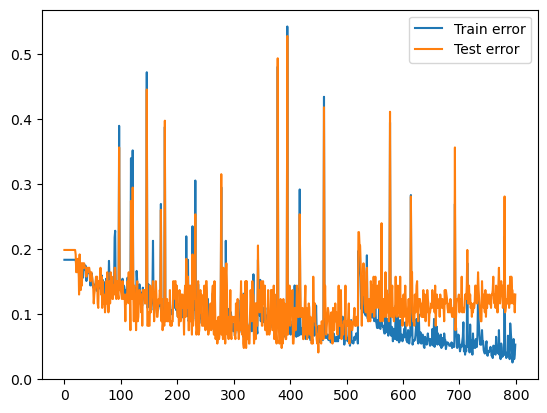

In [27]:
plt.plot(all_train_error, label = 'Train error')
plt.plot(all_test_error, label = 'Test error')
plt.legend()
plt.show()

In [28]:
print("Model's state_dict:")
for param_tensor in best_model.state_dict():
    print(param_tensor, "\t", best_model.state_dict()[param_tensor].size())

Model's state_dict:
rnn.weight_ih_l0 	 torch.Size([128, 6])
rnn.weight_hh_l0 	 torch.Size([128, 128])
rnn.bias_ih_l0 	 torch.Size([128])
rnn.bias_hh_l0 	 torch.Size([128])
rnn.weight_ih_l1 	 torch.Size([128, 128])
rnn.weight_hh_l1 	 torch.Size([128, 128])
rnn.bias_ih_l1 	 torch.Size([128])
rnn.bias_hh_l1 	 torch.Size([128])
rnn.weight_ih_l2 	 torch.Size([128, 128])
rnn.weight_hh_l2 	 torch.Size([128, 128])
rnn.bias_ih_l2 	 torch.Size([128])
rnn.bias_hh_l2 	 torch.Size([128])
rnn.weight_ih_l3 	 torch.Size([128, 128])
rnn.weight_hh_l3 	 torch.Size([128, 128])
rnn.bias_ih_l3 	 torch.Size([128])
rnn.bias_hh_l3 	 torch.Size([128])
rnn.weight_ih_l4 	 torch.Size([128, 128])
rnn.weight_hh_l4 	 torch.Size([128, 128])
rnn.bias_ih_l4 	 torch.Size([128])
rnn.bias_hh_l4 	 torch.Size([128])
rnn.weight_ih_l5 	 torch.Size([128, 128])
rnn.weight_hh_l5 	 torch.Size([128, 128])
rnn.bias_ih_l5 	 torch.Size([128])
rnn.bias_hh_l5 	 torch.Size([128])
fc.weight 	 torch.Size([2, 128])
fc.bias 	 torch.Size([2])

In [22]:
#save model
# torch.save(best_model_state, './sw_rnn_classify_construction_savedmodel.pt')


# model_scripted = torch.jit.script(model) # Export to TorchScript
# model_scripted.save('model_scripted.pt') # Save

In [23]:
#load model
# model2 = RNN(input_size, hidden_size, num_layers, num_classes).to(device)
# model2.load_state_dict(torch.load('./sw_rnn_classify_construction_savedmodel.pt'))
# model2.eval()

In [24]:
# predicted_test2 = model2(X_test)
# test_error2 = error_rate(predicted_test2, y_test)
# print(f"Saved model produces test data error =  {test_error2}")